In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Convert date columns
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [5]:
# Create customer features
customer_features = transactions_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean'],
    'ProductID': 'nunique',
    'TransactionID': 'count'
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'total_spend', 'avg_transaction', 'std_transaction', 
                           'total_quantity', 'avg_quantity', 'unique_products', 'transaction_count']

# Add customer region (one-hot encoded)
region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')
customer_features = pd.merge(customer_features, 
                           pd.concat([customers_df[['CustomerID']], region_dummies], axis=1),
                           on='CustomerID')

# Handle missing values and scale features
customer_features = customer_features.fillna(0)
scaler = StandardScaler()
feature_columns = customer_features.columns.drop('CustomerID')
scaled_features = scaler.fit_transform(customer_features[feature_columns])

C:\Users\vetal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vetal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vetal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vetal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

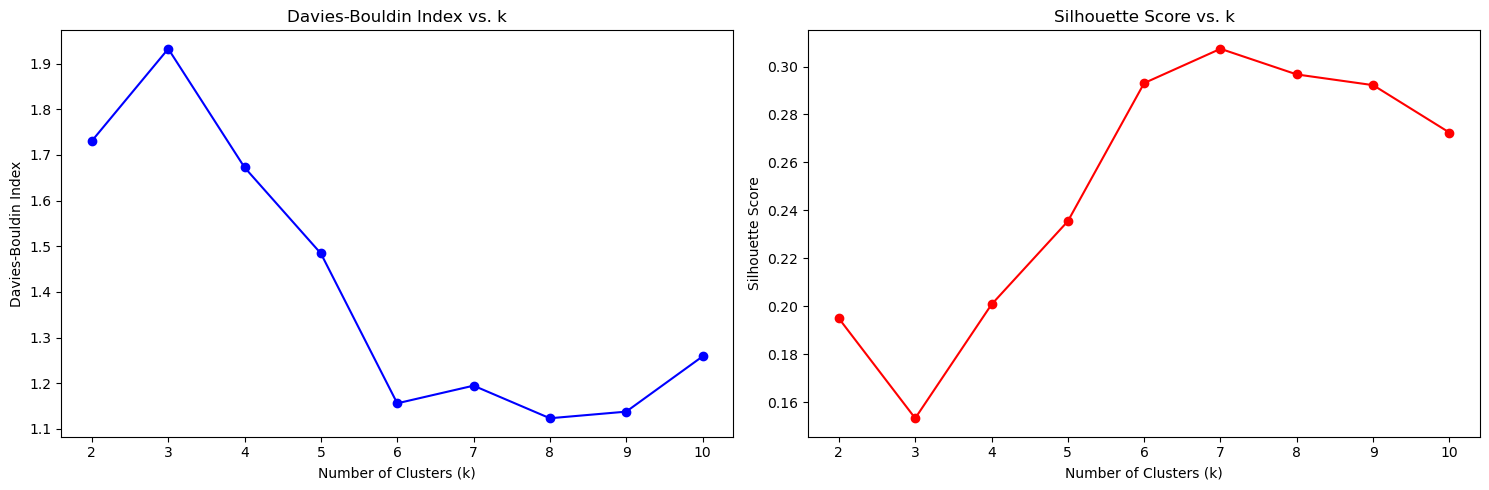

Optimal number of clusters based on Davies-Bouldin Index: 8


In [7]:
# Calculate DB Index for different numbers of clusters
db_scores = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    db_scores.append(davies_bouldin_score(scaled_features, clusters))
    silhouette_scores.append(silhouette_score(scaled_features, clusters))

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, db_scores, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Davies-Bouldin Index')
ax1.set_title('Davies-Bouldin Index vs. k')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs. k')

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k}")

C:\Users\vetal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


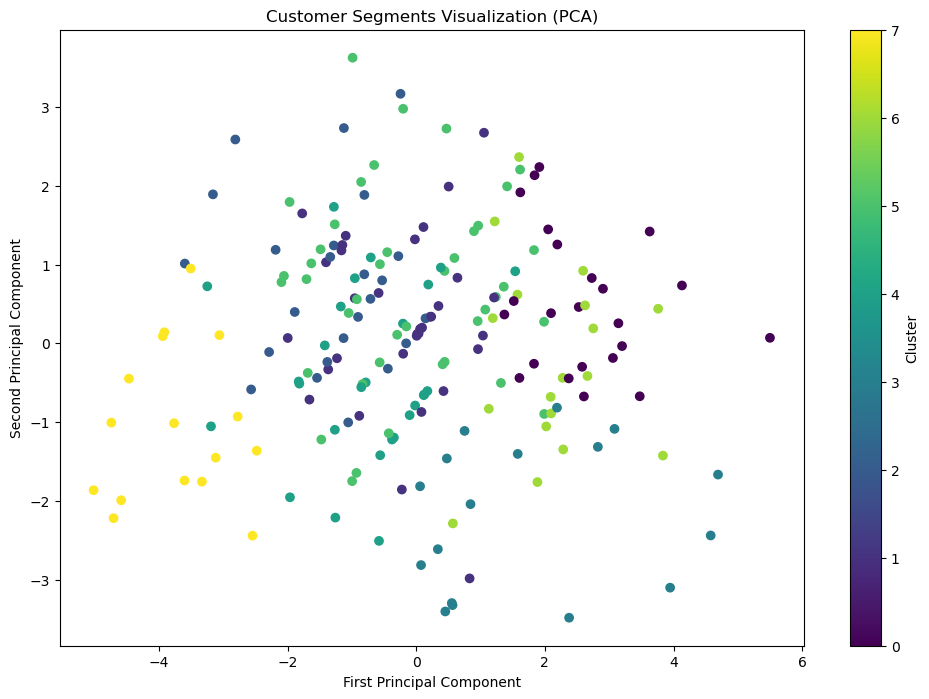

In [8]:
# Perform final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=customer_features['Cluster'], 
                     cmap='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [5]:
# Analyze cluster characteristics
cluster_stats = customer_features.groupby('Cluster').agg({
    'total_spend': ['mean', 'count'],
    'avg_transaction': 'mean',
    'transaction_count': 'mean',
    'unique_products': 'mean'
}).round(2)

print("Cluster Characteristics:")
print(cluster_stats)

# Save clustering results
clustering_results = pd.DataFrame({
    'CustomerID': customer_features['CustomerID'],
    'Cluster': customer_features['Cluster']
})
clustering_results.to_csv('Siddharth_Poonam_Clustering_Results.csv', index=False)

Cluster Characteristics:
        total_spend       avg_transaction transaction_count unique_products
               mean count            mean              mean            mean
Cluster                                                                    
0           5986.55    23          850.90              7.13            6.78
1           3053.81    33          673.97              4.67            4.58
2           2263.99    24          727.45              3.33            3.25
3           4658.39    17          587.20              7.94            7.82
4           2688.59    27          700.99              3.96            3.96
5           3394.79    41          745.65              4.68            4.61
6           5379.35    18          736.29              7.50            7.06
7            587.12    16          301.51              2.06            2.06
